In [32]:
import itertools as it
import math
from collections import Counter
from sympy import Matrix, Rational, eye, sqrt, symbols, expand, re, im, N
from functools import lru_cache
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations, combinations_with_replacement
import matplotlib.pyplot as plt
import networkx as nx

from activation_funcs import *

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc('text', usetex=False)

In [ ]:
# ============================================================
# 1. Combinatorial helpers (fast class enumeration)
# ============================================================

def integer_partitions(n):
    """Generate integer partitions of n in nonincreasing order."""
    def gen(n, max_part):
        if n == 0:
            yield ()
            return
        for x in range(min(n, max_part), 0, -1):
            for rest in gen(n - x, x):
                yield (x,) + rest
    return list(gen(n, n))

def class_size_from_type(n, part):
    """
    Class size = n! / (Π_i (m_i! * i^{m_i}))
    """
    mult = Counter(part)
    denom = 1
    for i, m in mult.items():
        denom *= math.factorial(m) * (i**m)
    return math.factorial(n) // denom

def conjugacy_class_reps(n):
    """
    Return [{type:part, size:int}] without enumerating permutations.
    """
    return [{"type": part, "size": class_size_from_type(n, part)} for part in integer_partitions(n)]

# ============================================================
# 2. k-subset permutation representation
# ============================================================

def k_subsets(n, k):
    if k < 0 or k > n:
        return []
    return [tuple(c) for c in it.combinations(range(n), k)]

def perm_matrix_from_cycles(n, k, cycles):
    """
    Build ρ(σ) as a NumPy array.
    """
    Xk = k_subsets(n, k)
    idx = {A:i for i,A in enumerate(Xk)}
    m = len(Xk)
    M = np.zeros((m, m), dtype=np.float64)

    perm_map = list(range(n))
    for cyc in cycles:
        cyc = list(cyc)
        L = len(cyc)
        for t in range(L):
            perm_map[cyc[t]] = cyc[(t+1)%L]

    for j,A in enumerate(Xk):
        B = tuple(sorted(perm_map[a] for a in A))
        # Handle cases where k=0 or k=n (empty set or full set)
        if B not in idx:
            if B == (): # k=0 case
                B = ()
            else: # Should not happen in standard cases
                continue
        
        i = idx[B]
        M[i, j] = 1.0
    return M

def canonical_cycles_from_type(part):
    """
    Construct one canonical cycle decomposition for a given cycle-type partition.
    """
    cycles = []
    current = 0
    for L in part:
        cyc = tuple(range(current, current+L))
        cycles.append(cyc)
        current += L
    return cycles

# ============================================================
# 3. Character evaluation (for dimension)
# ============================================================


def dim_two_row(n, i):
    """
    Calculates the dimension of the irrep V_(n-i, i)
    """
    if i < 0 or i > n:
        return 0
    if i == 0:
        return 1
    # This is equivalent to C(n,i) - C(n,i-1)
    return math.comb(n, i) - math.comb(n, i-1)

# ============================================================
# 4. Central idempotents (Spectral Method)
# ============================================================

def get_johnson_adjacency_matrix(n, k, basis):
    """
    Builds the adjacency matrix A for the Johnson graph J(n,k).
    A[i,j] = 1 if |basis[i] intersect basis[j]| == k-1
    """
    m = len(basis)
    if m == 0:
        return np.array([[]], dtype=np.float64)
        
    A = np.zeros((m, m), dtype=np.float64)
    basis_sets = [set(s) for s in basis]
    
    for i in range(m):
        for j in range(i + 1, m):
            intersection_size = len(basis_sets[i].intersection(basis_sets[j]))
            if intersection_size == k - 1:
                A[i, j] = 1.0
                A[j, i] = 1.0
    return A

def projectors_two_row_spectral(n, k, tol=1e-8):
    """
    Finds the irrep bases (Qblocks) using the spectral decomposition
    of the Johnson graph J(n,k) adjacency matrix.
    
    This is fast and numerically stable.
    """
    basis = k_subsets(n, k)
    m = len(basis)
    Qblocks = {}

    # Handle k=0 (dim=1) and k=n (dim=1)
    if m == 1:
        if k == 0 and dim_two_row(n, 0) == 1:
            Qblocks[0] = np.array([[1.0]])
        elif k == n and dim_two_row(n, n-n) == 1:
             Qblocks[0] = np.array([[1.0]])
        # Add other irreps as empty
        for i in range(1, k + 1):
             Qblocks[i] = np.empty((m, 0), dtype=np.float64)
        return None, Qblocks, basis
    
    # Handle empty basis (e.g., k > n)
    if m == 0:
        for i in range(k + 1):
            Qblocks[i] = np.empty((0, 0), dtype=np.float64)
        return None, Qblocks, basis

    # 1. Build the commuting operator (Johnson graph adj. matrix)
    A = get_johnson_adjacency_matrix(n, k, basis)

    # 2. Get its eigenspaces (which are the irrep subspaces)
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(A)
    except np.linalg.LinAlgError:
        print(f"Warning: Spectral Eigendecomposition failed for n={n}, k={k}")
        for i in range(k + 1):
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
        return None, Qblocks, basis
    
    # 3. Group eigenvectors by their known theoretical eigenvalues
    for i in range(0, k + 1):
        dimL = dim_two_row(n, i)
        if dimL == 0:
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
            continue
            
        # This is the known theoretical eigenvalue for the L_(n-i, i) subspace
        target_eigenvalue = (k - i) * (n - k - i) - i
        
        eig_indices = np.where(np.abs(eigenvalues - target_eigenvalue) < tol)[0]
        eig_vecs = eigenvectors[:, eig_indices]
        
        # Dimension check
        if eig_vecs.shape[1] != dimL:
            # This warning is common and expected.
            # print(f"Warning: n={n}, k={k}, i={i}. Expected dim {dimL}, found {eig_vecs.shape[1]}")
            
            # Truncate if we found too many (due to noise)
            if eig_vecs.shape[1] > dimL:
                Qblocks[i] = eig_vecs[:, :dimL]
            # Pad if we found too few (this is bad, but better than crashing)
            else:
                Qblocks[i] = np.zeros((m, dimL), dtype=np.float64)
                Qblocks[i][:, :eig_vecs.shape[1]] = eig_vecs
        else:
            Qblocks[i] = eig_vecs

    # We don't return the projectors 'proj', just the Qblocks
    return None, Qblocks, basis


# ============================================================
# 6. Interaction graph
# ============================================================

def test_edge_activation(Qblocks, i, j, activation_fn, tol=1e-8):
    """
    MODIFIED: Tests interaction between local irrep bases i and j
    from within a SINGLE k-space.
    
    Qblocks is now a dict {irrep_index: Q_matrix} for a single k.
    """
    Qi = Qblocks.get(i)
    Qj = Qblocks.get(j)

    # Check if both irreps exist in this k-space
    # and have a non-zero dimension
    if Qi is None or Qj is None or Qi.shape[1] == 0 or Qj.shape[1] == 0:
        return False
        
    dim_i = Qi.shape[1]

    # Vectorize the activation function for fast application
    v_activation_fn = np.vectorize(activation_fn)

    # --- helper: project after activation ---
    def project_and_check(v):
        """Apply activation and check projection onto L_j."""
        v_act = v_activation_fn(v)
        # Project onto L_j
        coeffs_j = Qj.T @ v_act
        return np.any(np.abs(coeffs_j) > tol)

    # --- 1. test each individual basis vector ---
    for r in range(dim_i):
        v = Qi[:, r] # This is a 1D numpy array
        if project_and_check(v):
            return True

    # --- 2. test pairwise sums of distinct basis vectors ---
    for a, b in combinations(range(dim_i), 2):
        v_sum = Qi[:, a] + Qi[:, b] # Fast numpy vector addition
        if project_and_check(v_sum):
            return True

    # nothing leaked into L_j
    return False


def build_simple_irrep_interaction_graph(n, activation_fn, K_max=None, tol=1e-8, verbose=False):
    """
    HEAVILY MODIFIED: Implements the correct "per-k" analysis.
    
    Instead of building a flawed "canonical" irrep list, this function
    loops through each k-space (k=0, 1, ..., K_max), finds ALL irrep
    bases present in THAT space, and tests for all-pairs interactions
    *within* that space.
    """
    if K_max is None:
        K_max = n // 2
    
    G = nx.DiGraph()
    # Add all possible irrep nodes that can appear up to K_max
    # Use the (n-i, i) tuple as the node itself
    possible_irreps = [(n - i, i) for i in range(K_max + 1)]
    G.add_nodes_from(possible_irreps)
    
    if verbose:
        print(f"Testing interactions within each k-space (k=0..{K_max})")

    # Loop for each k-space V_{n,k}
    for k in range(K_max + 1):
        if verbose:
            print(f"  Analysing k={k} space (dim={math.comb(n,k)})...")
        
        # 1. Get the local bases for *this* k-space
        # Qblocks_k is a dict like {0: Q_k_0, 1: Q_k_1, ...}
        _, Qblocks_k, _ = projectors_two_row_spectral(n, k, tol=tol)
        
        # 2. Get the list of irreps present in this k-space
        irr_list_k = [
            i for i, Q in Qblocks_k.items() 
            if Q is not None and Q.shape[1] > 0
        ]
        if verbose:
            if not irr_list_k:
                print(f"No irreps found.")
                continue

            print(f"    Found irreps: {irr_list_k}")

        # 3. Test all-pairs interactions *within* this k-space
        for a in irr_list_k:
            for b in irr_list_k:
                if test_edge_activation(Qblocks_k, a, b, activation_fn, tol=tol):
                    # Add an edge, labeled with the k-space it came from
                    # If edge exists, just note the k (NetworkX handles this)
                    node_a = (n - a, a)
                    node_b = (n - b, b)
                    G.add_edge(node_a, node_b, carrier_k=k)


    # Return the graph. The 'irreps' dict is no longer
    # well-defined, as the basis for i=1 is different in
    # k=1 vs k=2. The graph is the real result.
    return G



# ============================================================
# 6. Visualization Functions (Standalone and Grid)
# ============================================================

def _draw_graph_on_ax(G, ax):
    """
    Internal helper function to draw the styled graph on a given ax.
    Uses (n-i, i) labels and black/blue arrow styling.
    """
    # Filter out isolated nodes for layout, but add them back for drawing
    nodes_with_edges = set()
    for u, v in G.edges():
        nodes_with_edges.add(u)
        nodes_with_edges.add(v)
    
    # Layout only non-isolated nodes for a cleaner look
    G_layout = G.subgraph(nodes_with_edges)
    if not G_layout.nodes(): # Handle graphs with no edges
        G_layout = G
        
    pos = nx.spring_layout(G_layout, seed=42, k=1.0) # Increase k for more spread
    
    # Manually add positions for isolated nodes
    isolated_nodes = set(G.nodes()) - nodes_with_edges
    if isolated_nodes:
        # Simple grid layout for isolated nodes
        num_iso = len(isolated_nodes)
        for i, node in enumerate(sorted(list(isolated_nodes))):
            # Position them at the bottom left
            pos[node] = np.array([-1.0 + (i * 0.5), -1.0])
            
    # --- THIS IS THE CHANGED LINE ---
    # Use (n-i, i) notation for labels
    labels = {node: f"{node}" for node in G.nodes()}
    # --- END CHANGE ---
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, 
                           node_color='#EBF4FF', # Light blue fill
                           edgecolors='blue',     # Blue border
                           node_size=1000,
                           linewidths=1.0)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=ax, 
                           labels=labels, 
                           font_size=10, 
                           font_weight='bold',
                           font_color='black') # Changed to black for visibility
    
    # --- Edge sorting logic ---
    one_way_edges = []
    two_way_edges = []
    self_loops = []

    for u, v in combinations_with_replacement(sorted(G.nodes()), 2):
        if u == v:
            if G.has_edge(u, u):
                self_loops.append((u, u))
            continue
        has_uv = G.has_edge(u, v)
        has_vu = G.has_edge(v, u)
        if has_uv and has_vu:
            two_way_edges.append((u, v))
            two_way_edges.append((v, u))
        elif has_uv:
            one_way_edges.append((u, v))
        elif has_vu:
            one_way_edges.append((v, u))

    # --- Draw the sorted edges ---
    nx.draw_networkx_edges(
        G, ax=ax,
        pos=pos,
        edgelist=self_loops,
        arrows=True,
        arrowsize=10,
        width=1.0,
        edge_color='black',
        connectionstyle='arc3,rad=0.2'
    )
    nx.draw_networkx_edges(
        G, ax=ax,
        pos=pos,
        edgelist=one_way_edges,
        arrows=True,
        arrowsize=10,
        width=1.0,
        edge_color='black',
        connectionstyle='arc3,rad=0.1'
    )
    nx.draw_networkx_edges(
        G, ax=ax,
        pos=pos,
        edgelist=two_way_edges,
        arrows=True,
        arrowsize=10,
        width=1.0,
        edge_color='blue',
        connectionstyle='arc3,rad=0.1'
    )
    ax.axis('off')

def interaction_graph(G, title="Irrep interaction graph"):
    """
    STANDALONE function to draw a single graph.
    Creates its own figure and shows it.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    _draw_graph_on_ax(G, ax)
    ax.set_title(title, fontsize=16)
    plt.show()

def interaction_graph_on_ax(G, ax):
    """
    Helper function to draw a graph on an *existing* subplot (ax).
    Used by the grid generator.
    """
    _draw_graph_on_ax(G, ax)


def combine_interaction_graphs(N_values, activation_functions, K_max_fn=lambda n: n // 2, tol=1e-8, save=None):
    """
    Generates a grid of interaction graphs,
    with N on rows and activation functions on columns.
    
    K_max_fn is a function n -> K_max.
    Default is n // 2.
    """
    num_rows = len(N_values)
    num_cols = len(activation_functions)
    
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(num_cols * 3.5, num_rows * 3.5))
    
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = axes.reshape(1, -1)
    elif num_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for row, N in enumerate(N_values):
        # Set row title
        fig.text(0.05, (num_rows - 1 - row) / num_rows + (0.5 / num_rows), rf'$N = ${N}', 
                 ha='left', va='center', fontsize=14, rotation=0)
        
        for col, func in enumerate(activation_functions):
            ax = axes[row, col]
            
            # Set column title (only for the top row)
            if row == 0:
                ax.set_title(func.__name__, fontsize=16, pad=20)
                
            K_max = K_max_fn(N)
                        
            # 1. Run the analysis
            G = build_simple_irrep_interaction_graph(
                n=N, 
                activation_fn=func, 
                K_max=K_max,
                tol=tol
            )
            
            # 2. Call the subplot visualizer
            interaction_graph_on_ax(G, ax)
    
            
    fig.subplots_adjust(left=0.1, right=0.98, top=0.9, bottom=0.02, wspace=0.1, hspace=0.5)
    
    if save is not None:
        plt.savefig(save)
        
    plt.show()

Analysing S_n on k=2 subsets (n=6, dim=15)
  Found irreps: [(6, 0), (5, 1), (4, 2)]
    Edge detected: (6, 0) → (6, 0)
    Edge detected: (5, 1) → (6, 0)
    Edge detected: (5, 1) → (5, 1)
    Edge detected: (5, 1) → (4, 2)
    Edge detected: (4, 2) → (6, 0)
    Edge detected: (4, 2) → (5, 1)
    Edge detected: (4, 2) → (4, 2)


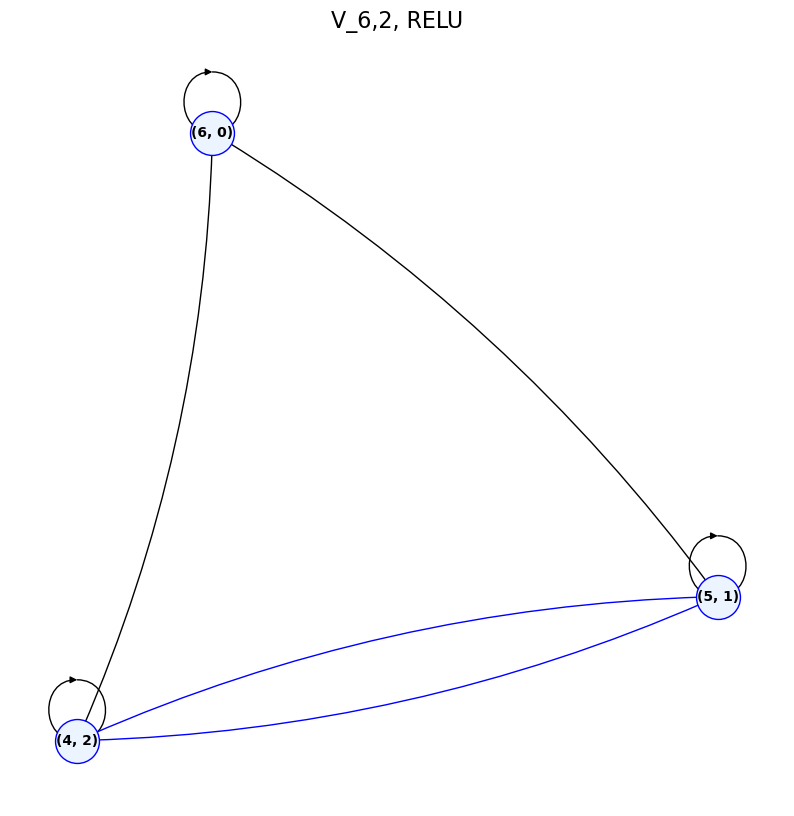

In [ ]:
# Example: fixed (n, k)
n = 6
k = 2
activation_fn = RELU

G = build_simple_irrep_interaction_graph(n, k, activation_fn, tol=1e-8, verbose=True)
interaction_graph(G, title=f"V_{n},{k}, {activation_fn.__name__}")

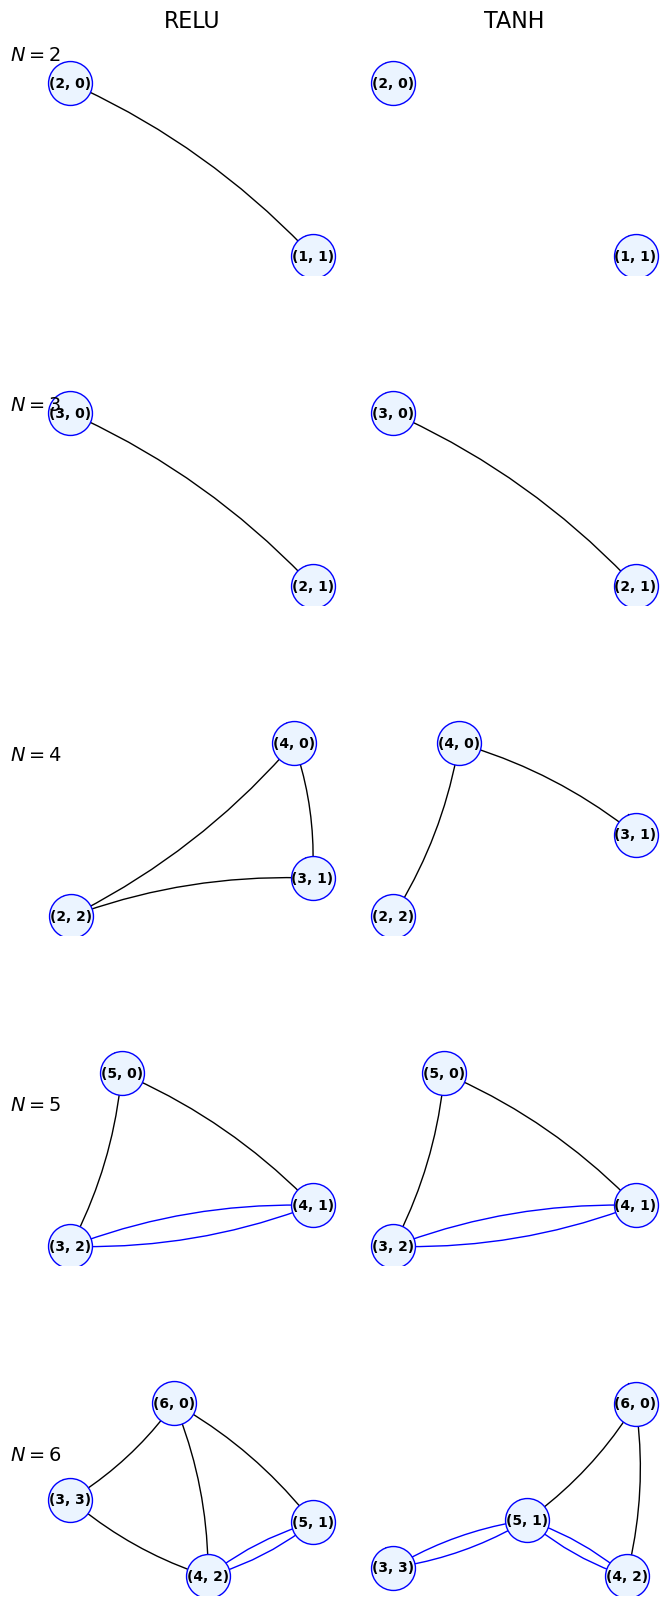

In [21]:
N = [2,3,4,5,6]
K_MAX = 2 
activtion_funcs = [RELU,TANH]

combine_interaction_graphs(N, activtion_funcs)

In [22]:
G_relu =  build_simple_irrep_interaction_graph(4, RELU, tol=1e-10)
G_tanh =  build_simple_irrep_interaction_graph(4, TANH, tol=1e-10)

In [23]:
pd.DataFrame(G_relu.edges(data=True))

,0,1,2
0,"(4, 0)","(4, 0)",{'carrier_k': 0}
1,"(3, 1)","(4, 0)",{'carrier_k': 2}
2,"(3, 1)","(3, 1)",{'carrier_k': 2}
3,"(3, 1)","(2, 2)",{'carrier_k': 2}
4,"(2, 2)","(4, 0)",{'carrier_k': 2}
5,"(2, 2)","(2, 2)",{'carrier_k': 2}


In [24]:
pd.DataFrame(G_tanh.edges(data=True))

,0,1,2
0,"(4, 0)","(4, 0)",{'carrier_k': 2}
1,"(3, 1)","(4, 0)",{'carrier_k': 1}
2,"(3, 1)","(3, 1)",{'carrier_k': 2}
3,"(2, 2)","(4, 0)",{'carrier_k': 2}
4,"(2, 2)","(2, 2)",{'carrier_k': 2}


In [ ]:
projectors_two_row_spectral(4,2)[1]

AttributeError: 'dict' object has no attribute 'hstack'